# outflank

In [350]:
proj_dir="/master/nplatt/sch_man_nwinvasion"
results_dir="{}/results".format(proj_dir)

In [351]:
os.chdir(proj_dir)
Path("{}/outflank".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/outflank".format(results_dir))

In [ ]:
%%bash 

#conda activate ~/sch_man_nwinvasion/envs/sch_man_nwinvasion-outflank

#remove the samples we aren't interested in
vcf-query -l ../phasing/auto_beagle.vcf \
    | grep -v rep \
    | grep -e Sm.BR -e Sm.TZ -e Sm.SN -e Sm.NE \
    >samples.list

vcftools \
    --vcf ../phasing/auto_beagle.vcf \
    --keep samples.list \
    --maf 0.05 \
    --recode \
    --recode-INFO-all \
    --stdout \
    >auto_beagle_maf05_ingroups.vcf
 
#go ahead and ld filter the snot of out the file as well
plink \
    --vcf auto_beagle_maf05_ingroups.vcf \
    --allow-extra-chr \
    --double-id \
    --indep-pairwise 1000 5 0.20 \
    --out big_filt

vcftools \
    --vcf auto_beagle_maf05_ingroups.vcf \
    --exclude auto_beagle_maf05_ingroups_ld_filtered.prune.out \
    --recode \
    --recode-INFO-all \
    --stdout \
    --thin 10000 \
    >auto_beagle_maf05_ingroups_ld_filtered.vcf



In [3]:
%load_ext rpy2.ipython

/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-outflank/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:81: UserWarning: The Python package `pandas` is strongly recommended when using `rpy2.ipython`. Unfortunately it could not be loaded, as we did not manage to load `numpy` in the first place (error: No module named 'numpy').
  warnings.warn('The Python package `pandas` is strongly '


In [40]:
%%R 

#install.packages('vcfR', repos='http://cran.us.r-project.org')
library("vcfR")
library("qvalue")
library("dartR")
library("devtools")
library("adegenet")

#devtools::install_github("whitlock/OutFLANK")
library("OutFLANK")

#read in vcf
vcfr <- read.vcfR("auto_beagle_maf05_ingroups.vcf")

# Convert to genind object
genind = vcfR2genind(vcfr)

# Add site IDs to genind object
pops=read.csv("pops.list")
genind$pop = as.factor(substr(indNames(genind), 4, 5))

#make locus names
pos <- getPOS(vcfr)
chr <- getCHROM(vcfr)
locus_names<-paste(chr, pos, sep=":")

Scanning file to determine attributes.
File attributes:
  meta lines: 9
  header_line: 10
  variant count: 38202
  column count: 144
Meta line 9 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 38202
  Character matrix gt cols: 144
  skip: 0
  nrows: 38202
  row_num: 0
Processed variant: 00020003000400050006000700080009000100001100012000130001400015000160001700018000190002000021000220002300024000250002600027000280002900030000310003200033000340003500036000370003800038202
All variants processed


In [ ]:
%%R
locus_names

Calculating FSTs, may take a few minutes...
[1] "10000 done of 76404"
[1] "20000 done of 76404"
[1] "30000 done of 76404"
[1] "40000 done of 76404"
[1] "50000 done of 76404"
[1] "60000 done of 76404"
[1] "70000 done of 76404"


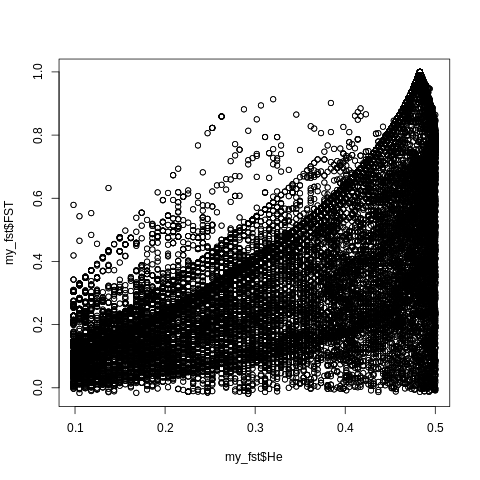

In [41]:
%%R

my_fst <- MakeDiploidFSTMat(genind$tab, locusNames=genind$all.names, popNames = genind$pop)
headhead
#png(filename = "he_vs_fst.png");
plot(my_fst$He, my_fst$FST)
#dev.off();

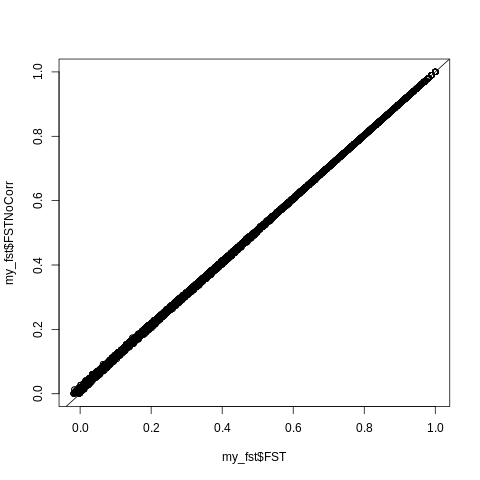

In [7]:
%%R

#png(filename = "fst_vs_fstnocor.png");
plot(my_fst$FST, my_fst$FSTNoCorr)
abline(0,1)
#dev.off();

In [53]:
%%R

#get unlinked variants
unlinked_ids<-read.csv("auto_beagle_maf05_ingroups_ld_filtered.prune.in")

neutral_idxs<-c()
for (locus_name in unlinked_ids) {
    idx <- match(locus_name,locus_names)
    neutral_idxs <- append(neutral_idxs, idx)
}

out_trim <- OutFLANK(my_fst[neutral_idxs,], NumberOfSamples=4, qthreshold = 0.05, Hmin = 0.1)

summary(out_trim)

                      Length Class      Mode   
FSTbar                 1     -none-     numeric
FSTNoCorrbar           1     -none-     numeric
dfInferred             1     -none-     numeric
numberLowFstOutliers   1     -none-     numeric
numberHighFstOutliers  1     -none-     numeric
results               15     data.frame list   


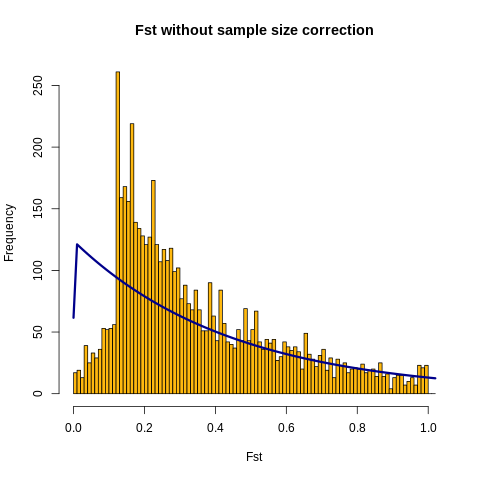

In [51]:
%%R

#png(filename = "neutral_fst.png");
OutFLANKResultsPlotter(out_trim, 
                       withOutliers = TRUE,
                       NoCorr = TRUE, 
                       Hmin = 0.1, 
                       binwidth = 0.001, 
                       Zoom = FALSE, 
                       RightZoomFraction = 0.05, 
                       titletext = NULL)

#dev.off()

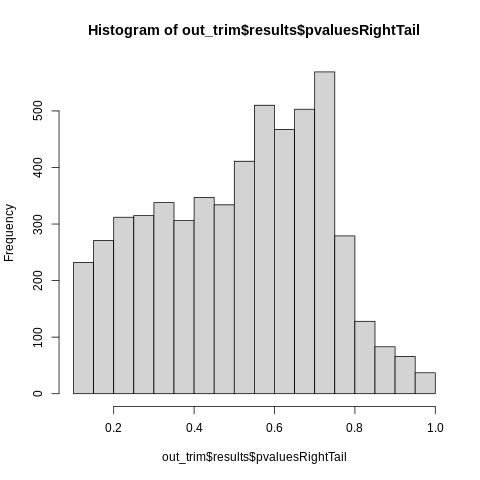

In [56]:
%%R

hist(out_trim$results$pvaluesRightTail)

In [57]:
%%R

P1 <- pOutlierFinderChiSqNoCorr(my_fst, 
                                Fstbar = out_trim$FSTNoCorrbar, 
                                dfInferred = out_trim$dfInferred, 
                                qthreshold = 0.05, 
                                Hmin=0.1)

In [14]:
%%R
#head(P1)

which(P1$OutlierFlag == TRUE)

integer(0)


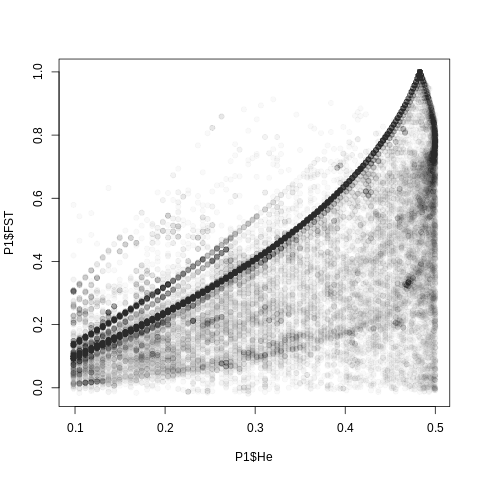

In [64]:
%%R

my_out <- P1$OutlierFlag==TRUE
plot(P1$He, P1$FST, pch=19, col=rgb(0,0,0,0.01))
points(P1$He[my_out], P1$FST[my_out], col="blue")

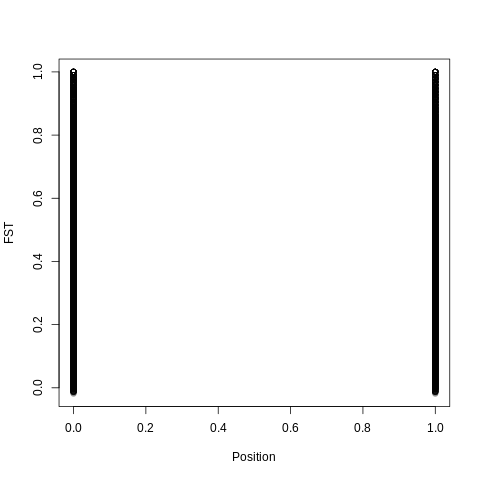

In [66]:
%%R

plot(P1$LocusName[P1$He>0.1], P1$FST[P1$He>0.1],
     xlab="Position", ylab="FST", col=rgb(0,0,0,0.2))
  points(P1$LocusName[my_out], P1$FST[my_out], col="magenta", pch=20)  

In [ ]:
%%R
hist(P1$FST)

# Pcadapt

https://bcm-uga.github.io/pcadapt/articles/pcadapt.html


In [ ]:
%%bash

plink \
    --vcf auto_beagle_maf05_ingroups.vcf \
    --allow-extra-chr \
    --double-id \
    --make-bed

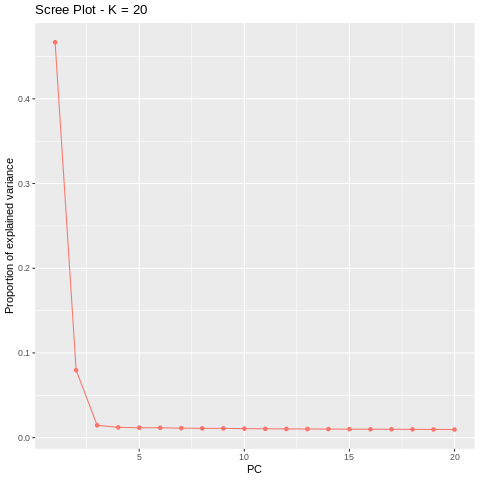

In [16]:
%%R

#install.packages("pcadapt")
library(pcadapt)


path_to_file <- "plink.bed"
plink_file <- read.pcadapt(path_to_file, type = "bed")

x <- pcadapt(input = plink_file, K = 20)

#png(filename = "screeplot.png");
plot(x, option = "screeplot")
#dev.off()

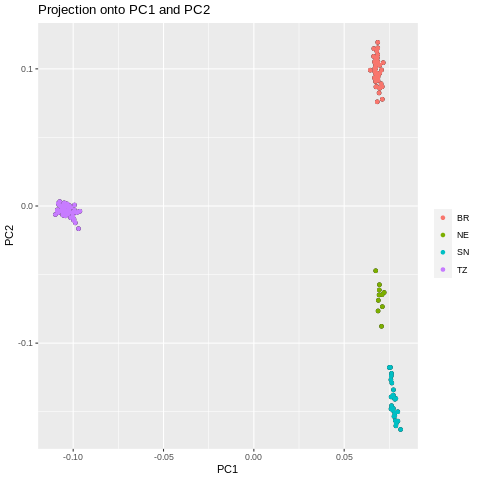

In [17]:
%%R

# With integers
pop_csv<-read.csv("pops.list", header=FALSE, stringsAsFactors = TRUE)
poplist<-pop_csv$V1

#png(filename = "pcadapt_scores_pc1-2.png")
plot(x, option = "scores", pop = poplist)
#dev.off()

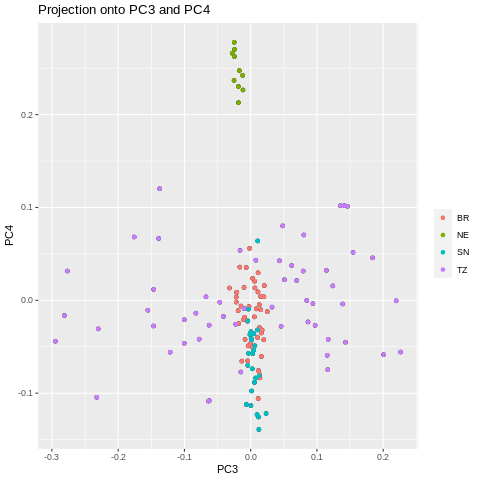

In [18]:
%%R

#png(filename = "pcadapt_scores_pc3-4.png")
plot(x, option = "scores", i = 3, j = 4, pop = poplist)
#dev.off()

In [19]:
%%R

x <- pcadapt(plink_file, K = 2)

summary(x)

                Length Class  Mode   
scores            270  -none- numeric
singular.values     2  -none- numeric
loadings        76404  -none- numeric
zscores         76404  -none- numeric
af              38202  -none- numeric
maf             38202  -none- numeric
chi2.stat       38202  -none- numeric
stat            38202  -none- numeric
gif                 1  -none- numeric
pvalues         38202  -none- numeric
pass            38202  -none- numeric


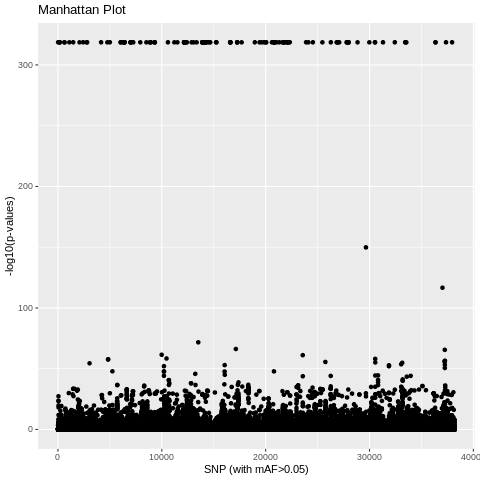

In [20]:
%%R

#png(filename = "pcadapt_manhattan_k2.png")
plot(x , option = "manhattan")
#dev.off()

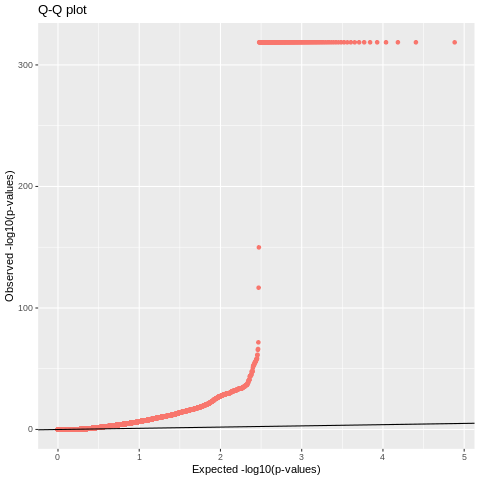

In [21]:
%%R

#png(filename = "pcadapt_qq_k2.png")
plot(x, option = "qqplot")
#dev.off()

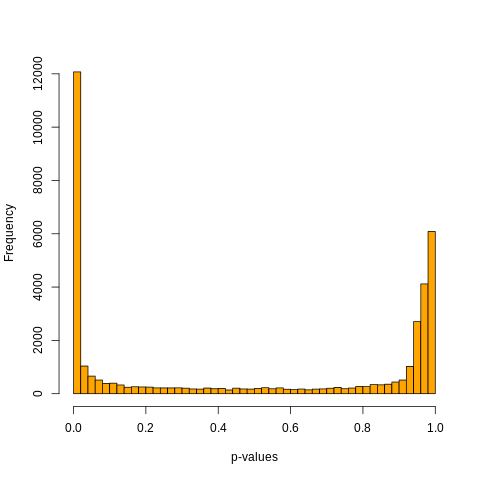

In [22]:
%%R

#png(filename = "pcadapt_pvalues_k2.png")
hist(x$pvalues, xlab = "p-values", main = NULL, breaks = 50, col = "orange")
#dev.off()

In [23]:
%%R

#bonferonni correction
padj <- p.adjust(x$pvalues,method="bonferroni")
alpha <- 0.05
outliers <- which(padj < alpha)
length(outliers)

[1] 4244


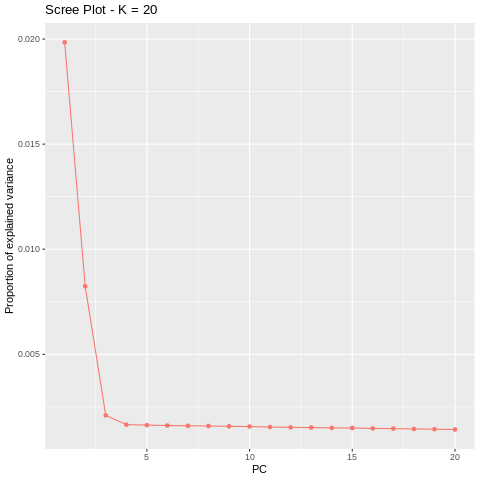

In [26]:
%%R

#ld thinned
ld_x <- pcadapt(input = plink_file, K = 20, LD.clumping = list(size = 1000, thr = 0.2))
#png(filename = "screeplot_ldthinned.png");
plot(ld_x, option = "screeplot")
#dev.off()

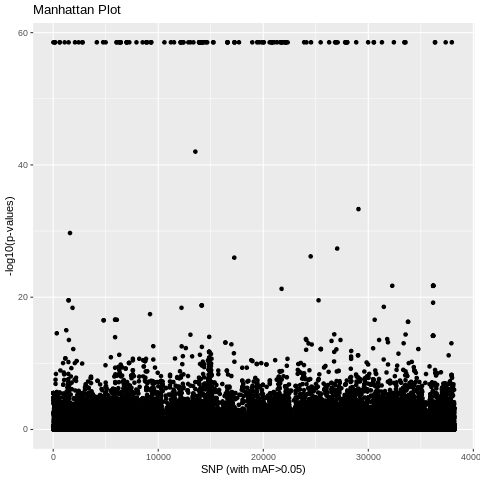

In [27]:
%%R

#png(filename = "pcadapt_manhattan_k2_ldthinned.png")
plot(ld_x , option = "manhattan")
#dev.off()

In [28]:
%%R

padj <- p.adjust(ld_x$pvalues,method="bonferroni")
alpha <- 0.05
outliers <- which(padj < alpha)
length(outliers)

[1] 951


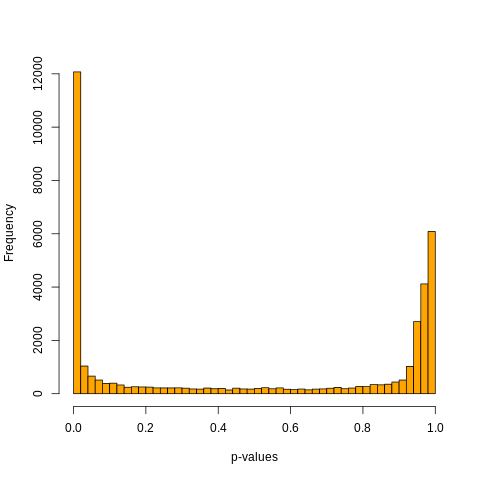

In [30]:
%%R

#png(filename = "pcadapt_pvalues_k2.png")
hist(x$pvalues, xlab = "p-values", main = NULL, breaks = 50, col = "orange")
#dev.off()

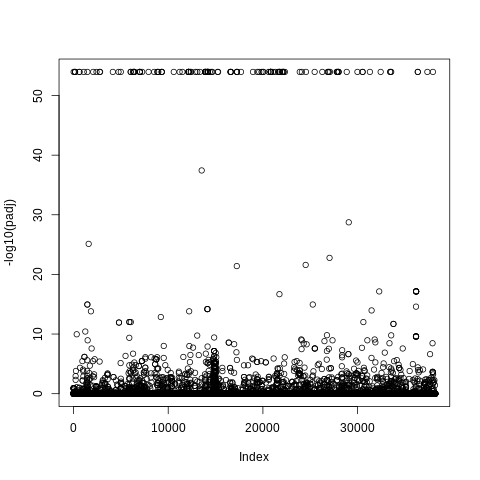

In [36]:
%%R

#png(filename = "pcadapt_manhattan_k2_-log-q.png")
plot(-log10(padj) , option = "manhattan")
#dev.off()

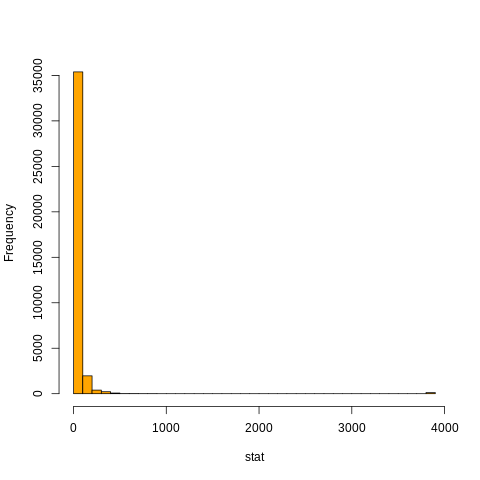

In [37]:
%%R

#png(filename = "pcadapt_stat_k2.png")
hist(x$stat, xlab = "stat", main = NULL, breaks = 50, col = "orange")
#dev.off()

In [38]:
%%R

cs<- 1-pchisq(x$stat, df=2, lower.tail=FALSE)
padj <- p.adjust(cs, method="bonferroni")
alpha <- 0.05
outliers <- which(padj < alpha)
length(outliers)

[1] 0


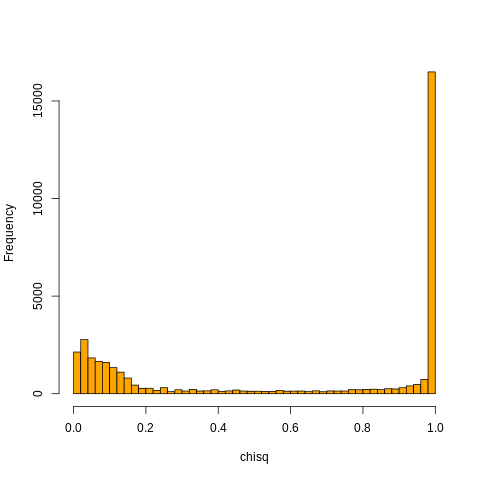

In [39]:
%%R

#png(filename = "pcadapt_chi2_k2.png")
hist(cs, xlab = "chisq", main = NULL, breaks = 50, col = "orange")
#dev.off()